# Librerias y data

In [1]:
import pandas as pd
import numpy as np
import re
import demoji
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import folium
from folium import plugins, Marker
from folium.plugins import MarkerCluster

In [12]:
df_reviews = pd.read_csv("data/reviews.csv", sep=";", parse_dates=["date"])

In [13]:
df_lodgings = pd.read_csv("data/lodgings.csv", sep=";")

In [3]:
df_lodgings.to_parquet("data/df_lodgings.parquet", compression="gzip", index=False)

In [14]:
df = df_reviews.merge(df_lodgings, on="lodging_id")

In [15]:
df.shape

(36239, 11)

In [16]:
nltk.download('stopwords') # DESCARGAR UNA VEZ
nltk.download('punkt')

[nltk_data] Downloading package stopwords to C:\Users\ASUS
[nltk_data]     X515\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\ASUS
[nltk_data]     X515\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [17]:
stopwords_nltk = stopwords.words('english') + list(["hotel", "positive", "negative"])

In [18]:
np.array(stopwords_nltk)

array(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
       "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself',
       'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her',
       'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them',
       'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom',
       'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are',
       'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
       'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and',
       'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at',
       'by', 'for', 'with', 'about', 'against', 'between', 'into',
       'through', 'during', 'before', 'after', 'above', 'below', 'to',
       'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under',
       'again', 'further', 'then', 'once', 'here', 'there', 'when',
       'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'm

# Transformacion

In [19]:
from nltk.sentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def sentiment(text):
  if not text: # SI EL TEXTO ESTA VACIO DESPUES DE LA LIMPIEZA, EL SCORE ES NEUTRO
    return 0
  else:   # SI NO ESTA VACIO, VADER LO CALCULA
    scores = analyzer.polarity_scores(text)
  return scores["compound"]

In [20]:
def cleaning_text(text):
# TRATAR TRADUCCIONES EN REVIEWS, BORRA EL STRING "(ORIGINAL)" Y TODO A SU DERECHA
  keyword = "(Original)"
  keyword_index = text.find(keyword) # Encontrar la posición de la palabra clave
  if keyword_index != -1:
      text = text[:keyword_index + len(keyword)] # Eliminar todo después de la palabra clave

  text = text.replace("(Original)", "")
  text = text.replace("(Translated by Google)", "")

# TRATAR EMOJIS
  text = demoji.replace_with_desc(text, ' ') # reemplaza los emojis con palabras mas un espacio entre si

# BORRAR SALTOS DE LINEA
  text = text.replace("\n", " ")
# BORRAR ESPACIOS AL PRINCIPIO Y AL FINAL Y CONVERTIR A MINUSCULAS
  text = text.strip()
  text = text.lower()
# DESPUES DE LIMPIADO VERIFICAR SI HAY CARACTERES O NO, SI NO HAY CONVERTIRLOS EN NULO
  if not text:
      return None
  return text

def remove_stopwords(text):
    if text is None:
        return ""  # Devolver una cadena vacía si el texto es None o está vacío   
    # Utilizar una expresión regular para tokenizar el texto preservando las palabras con apóstrofes
    tokenizer = RegexpTokenizer(r'\w+\'\w+|\w+')
    tokens = tokenizer.tokenize(text)
    
    filtered_sentence = []
    for token in tokens:
        if token.lower() not in stopwords_nltk:
            filtered_sentence.append(token)
    text = ' '.join(filtered_sentence)
    # BORRAR CARACTERES NO ALFANUMERICOS
    text = re.sub(r'[^\w\s]', '', text)
    return text

In [21]:
df["cleaned"] = [cleaning_text(x) for x in df["review"]]

In [22]:
df["stopwords_removed"] = [remove_stopwords(x) for x in df["cleaned"]]

In [23]:
df["score_sentiment"] = [sentiment(x) for x in df["cleaned"]]

In [24]:
df.to_parquet("data/df_transformed.parquet", compression="gzip", index=False)

# Wordclouds

In [25]:
df.head(3)

review_id  lodging_id  guest_id       date  \
0          1           1         1 2021-08-08   
1          2           1         2 2021-03-16   
2          3           1         3 2021-02-04   

                                              review  rating  \
0  Good for when you're in a pinch. More availabi...     3.0   
1  Getting much better very sweet receptionists. ...     5.0   
2  This is the best I've seen their property in y...     4.0   

                            lodging_code                lodging_name  \
0  0x80c8dae62e7dbaaf:0xd30feda3d0851444  The Suites Boulder Highway   
1  0x80c8dae62e7dbaaf:0xd30feda3d0851444  The Suites Boulder Highway   
2  0x80c8dae62e7dbaaf:0xd30feda3d0851444  The Suites Boulder Highway   

    latitude   longitude state  \
0  36.116725 -115.067942    NV   
1  36.116725 -115.067942    NV   
2  36.116725 -115.067942    NV   

                                             cleaned  \
0  good for when you're in a pinch. more availabi...   
1  getting much better very sweet receptionists. ...   
2  this is the best i've seen their property in y...   

                                   stopwords_removed  score_sentiment  
0  good pinch availability days baby roach hoards...           0.9315  
1  getting much better sweet receptionists securi...           0.9455  
2  best ive seen property years riff raff securit...           0.8834

In [63]:
ramada_df = df[df['lodging_name'].str.contains('Ramada', case=False)]

In [64]:
ramada_df.groupby(["lodging_code", "lodging_name"]).agg("count")

review_id  \
lodging_code                          lodging_name                                                    
0x88c2e5a2ebb025a7:0x9a14452d84f10f2b Ramada Clearwater Airport                                   9   
0x89d373d8874f5df7:0x3c873465b0462ea1 Ramada Amherst/Getzville Hotel and Conference C...         13   
0x89d6b356de5cf997:0xe57c81d729b0637e Ramada Plaza by Wyndham Rochester Airport                  48   
ChIJ135FAZC4woARl-n5J1-_9Bc           Ramada by Wyndham Los Angeles/Koreatown West              335   
ChIJQ2jYnfx-54gRWdztOAOGn9M           Ramada Plaza by Wyndham Orlando Resort & Suites...       1617   
ChIJV_pvpbu-woARQ85y4CokD4s           Ramada Plaza by Wyndham West Hollywood Hotel & ...        873   
ChIJXfjqkJZZwokRTwca33qw-00           Ramada by Wyndham New York Times Square West              301   
ChIJY5H7s6SZ7ocRo0_nWCZdZj0           Ramada by Wyndham Reno Hotel & Casino                    1301   
ChIJZWXzpqG2woARMhdDcxEGQiU           Ramada by Wyndham Hawthorne/LA Stadium                      5   
ChIJZbi0Q5jHwoARaQEG2qWzG8U           Ramada by Wyndham Los Angeles/Downtown West                 5   
ChIJiZIKGr62QIYRf-KFFJ3cBTQ           Ramada by Wyndham Houston Intercontinental Airp...        903   
ChIJx6erZ42zQIYRaglFH8e2838           Ramada by Wyndham Houston Intercontinental Airp...       1010   
IF8dc3xSgF_mLDq-bnhOlQ                Ramada                                                     14   

                                                                                          lodging_id  \
lodging_code                          lodging_name                                                     
0x88c2e5a2ebb025a7:0x9a14452d84f10f2b Ramada Clearwater Airport                                    9   
0x89d373d8874f5df7:0x3c873465b0462ea1 Ramada Amherst/Getzville Hotel and Conference C...          13   
0x89d6b356de5cf997:0xe57c81d729b0637e Ramada Plaza by Wyndham Rochester Airport                   48   
ChIJ135FAZC4woARl-n5J1-_9Bc           Ramada by Wyndham Los Angeles/Koreatown West               335   
ChIJQ2jYnfx-54gRWdztOAOGn9M           Ramada Plaza by Wyndham Orlando Resort & Suites...        1617   
ChIJV_pvpbu-woARQ85y4CokD4s           Ramada Plaza by Wyndham West Hollywood Hotel & ...         873   
ChIJXfjqkJZZwokRTwca33qw-00           Ramada by Wyndham New York Times Square West               301   
ChIJY5H7s6SZ7ocRo0_nWCZdZj0           Ramada by Wyndham Reno Hotel & Casino                     1301   
ChIJZWXzpqG2woARMhdDcxEGQiU           Ramada by Wyndham Hawthorne/LA Stadium                       5   
ChIJZbi0Q5jHwoARaQEG2qWzG8U           Ramada by Wyndham Los Angeles/Downtown West                  5   
ChIJiZIKGr62QIYRf-KFFJ3cBTQ           Ramada by Wyndham Houston Intercontinental Airp...         903   
ChIJx6erZ42zQIYRaglFH8e2838           Ramada by Wyndham Houston Intercontinental Airp...        1010   
IF8dc3xSgF_mLDq-bnhOlQ                Ramada                                                      14   

                                                                                          guest_id  \
lodging_code                          lodging_name                                                   
0x88c2e5a2ebb025a7:0x9a14452d84f10f2b Ramada Clearwater Airport                                  9   
0x89d373d8874f5df7:0x3c873465b0462ea1 Ramada Amherst/Getzville Hotel and Conference C...        13   
0x89d6b356de5cf997:0xe57c81d729b0637e Ramada Plaza by Wyndham Rochester Airport                 48   
ChIJ135FAZC4woARl-n5J1-_9Bc           Ramada by Wyndham Los Angeles/Koreatown West             335   
ChIJQ2jYnfx-54gRWdztOAOGn9M           Ramada Plaza by Wyndham Orlando Resort & Suites...      1617   
ChIJV_pvpbu-woARQ85y4CokD4s           Ramada Plaza by Wyndham West Hollywood Hotel & ...       873   
ChIJXfjqkJZZwokRTwca33qw-00           Ramada by Wyndham New York Times Square West             301   
ChIJY5H7s6SZ7ocRo0_nWCZdZj0           Ramada by Wyndham Reno Hote

In [65]:
df_filtrado = ramada_df[ramada_df['lodging_name'] == "Ramada by Wyndham Houston Intercontinental Airport South"]

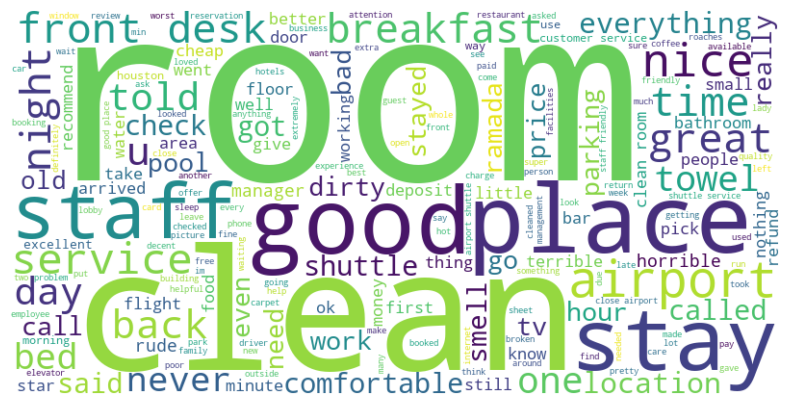

In [66]:
text = ' '.join(df_filtrado['transformed'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Mapas

In [2]:
df_lodgings = pd.read_parquet("data/df_lodgings.parquet")

In [3]:
df_lodgings.head(2)

lodging_id                           lodging_code  \
0           1  0x80c8dae62e7dbaaf:0xd30feda3d0851444   
1           2  0x80990aa2fd553e63:0x151102a1b673901c   

                 lodging_name   latitude   longitude state  
0  The Suites Boulder Highway  36.116725 -115.067942    NV  
1            Silver Queen Inn  39.167694 -119.768219    NV

In [18]:
map_center = [df_lodgings['latitude'].mean(), df_lodgings['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=4)

In [19]:
# Agregar marcadores para los hoteles en el mapa
for index, row in df_lodgings.iterrows():
    folium.Marker([row['latitude'], row['longitude']], tooltip=row['lodging_name']).add_to(m)

In [20]:
# Habilitar el plugin "MousePosition" para mostrar las coordenadas en la parte inferior del mapa
plugins.MousePosition(position='bottomleft').add_to(m)

In [21]:
# Agregar un control de clic al mapa
map_click = folium.Map(location=map_center, zoom_start=4)

La totalidad de los hoteles en el mapa demora en cargar. Ahora se repite usando clusters

In [ ]:
m_2 = folium.Map(location=map_center, tiles='cartodbpositron', zoom_start=5)

# Crear un clúster de marcadores
mc = MarkerCluster()

for idx, row in df_lodgings.iterrows():
    if not pd.isna(row['longitude']) and not pd.isna(row['latitude']):
        # Agregar un marcador con el nombre del hotel como popup
        marcador = folium.Marker(
            location=[row['latitude'], row['longitude']],
            tooltip=row['lodging_name']  # tooltip para que muestre el nombre cuando se pose, popup lo muestra al click
        )
        marcador.add_to(mc)

# Agregar el clúster de marcadores al mapa principal
m_2.add_child(mc)

Resaltando los hoteles elegidos

In [31]:
# Crear un clúster de marcadores para hoteles seleccionados
mc_selected = MarkerCluster()

# Crear un clúster de marcadores para hoteles no seleccionados
mc_unselected = MarkerCluster()

hoteles_seleccionados = ["Ramada Plaza by Wyndham Orlando Resort & Suites Intl Drive", "Ramada by Wyndham New York Times Square West",
            "Ramada Plaza by Wyndham West Hollywood Hotel & Suites",  "Ramada by Wyndham Reno Hotel & Casino", 
            "Ramada by Wyndham Houston Intercontinental Airport South", "Ramada by Wyndham Houston Intercontinental Airport East"]

In [35]:
m_3 = folium.Map(location=map_center, tiles='cartodbpositron', zoom_start=4.5)

for idx, row in df_lodgings.iterrows():
    if not pd.isna(row['longitude']) and not pd.isna(row['latitude']):
        # Verificar si el hotel está en la lista de hoteles seleccionados
        if row['lodging_name'] in hoteles_seleccionados:
            # Agregar un marcador con estilo diferente para hoteles seleccionados
            marcador = folium.Marker(
                location=[row['latitude'], row['longitude']],
                tooltip=row['lodging_name'],  # tooltip para que muestre el nombre cuando se pose
                icon=folium.Icon(color='red', icon='info-sign')  # Cambia el color del icono a rojo
            )
            marcador.add_to(mc_selected)
        else:
            # Agregar un marcador normal para hoteles no seleccionados
            marcador = folium.Marker(
                location=[row['latitude'], row['longitude']],
                tooltip=row['lodging_name']  # tooltip para que muestre el nombre cuando se pose
            )
            marcador.add_to(mc_unselected)

# Agregar los clústeres de marcadores al mapa principal
m_3.add_child(mc_selected)
m_3.add_child(mc_unselected)


# Por categoria

In [2]:
df_categoria = pd.read_parquet("data/reviews-model.parquet")

In [3]:
df_categoria.head(2)

review_id  lodging_id  guest_id        date  \
0         43         811        42  2020-10-19   
1        140         811       135  2017-03-16   

                                              review  rating  \
0  Decent location good prices and diamonds casin...       4   
1  Nice hotel friendly check in staff. Cocktail s...       4   

   overall_sentiment  room_sentiment  guest_service_sentiment  \
0                  1               0                        0   
1                 -1               1                       -1   

   cleaning_sentiment  breakfast_sentiment  sentiment_score  \
0                   0                    0           0.7003   
1                   0                    0           0.9022   

                                        clean_review  \
0  decent location good price diamond casino plac...   
1  nice hotel friendly check staff cocktail serve...   

                                     clean_stopwords  
0  decent location good price diamond casino plac...  
1  nice friendly check staff cocktail server coul...

In [12]:
def WC(df_wc,titulo):
    # tokenizando
    text = df_wc['cleaned_review'].str.cat()
    text = text.lower()  # Convierte a minúsculas
    text = ''.join([c for c in text if c.isalpha() or c.isspace()])
    words = nltk.word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]  # Elimina palabras vacías


    # Análisis de frecuencia de palabras
    freq_dist = nltk.FreqDist(words)
    # Creación de la Word Cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dist)

    
    # Visualización
    plt.figure(figsize=(10, 5))
    plt.title(titulo, fontsize=16)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

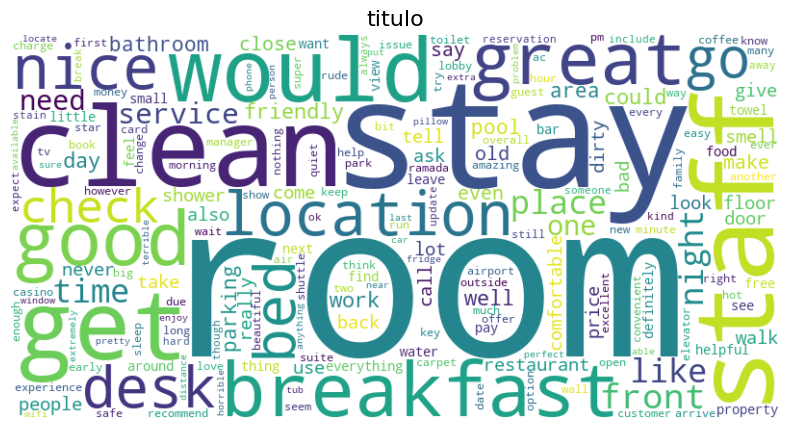

In [13]:
WC(df_categoria, "titulo")